
<style>
div.text_cell_render {
    font-size: 12px; /* Adjust this to a smaller number if needed */
}

div.output_area pre {
    font-size: 6px; /* For code output */
}

.CodeMirror {
    font-size: 8px; /* For code cells */
}
</style>

# 1. Single Perceptron

In [55]:
import torch
import random
import matplotlib.pyplot as plt

# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [56]:
def generate_one_like_pattern():
    # Start with random 0/1 pattern
    pattern = (torch.rand(25) > 0.3).float()  # About 70% chance to be 1
    # (Optional) enforce a vertical line in the center column:
    # index of center column pixels in a flattened 5x5: these indices are 2,7,12,17,22
    center_col_indices = [2,7,12,17,22]
    pattern[center_col_indices] = 1.0
    return pattern

# Function to create a random pattern that resembles "0"
def generate_zero_like_pattern():
    # Generate a pattern with a border of 1s and random inside
    pattern = torch.zeros(5,5)
    # Set border to 1
    pattern[0,:] = 1
    pattern[-1,:] = 1
    pattern[:,0] = 1
    pattern[:,-1] = 1
    # Inside random 0/1 with lower probability of 1
    inside = (torch.rand(3,3) > 0.8).float()  # About 20% chance to be 1 inside
    pattern[1:4,1:4] = inside
    return pattern.flatten()

def run_simulation(ones, zeros, alpha=0.1, max_epochs=1000):
    # Randomly select training and test patterns
    one_indices = torch.randperm(len(ones))
    zero_indices = torch.randperm(len(zeros))

    train_ones = [ones[i] for i in one_indices[:4]]
    test_ones = [ones[i] for i in one_indices[4:]]
    train_zeros = [zeros[i] for i in zero_indices[:4]]
    test_zeros = [zeros[i] for i in zero_indices[4:]]

    X_train = torch.stack(train_ones + train_zeros)
    d_train = torch.tensor([1]*4 + [-1]*4, dtype=torch.float32)
    X_test = torch.stack(test_ones + test_zeros)
    d_test = torch.tensor([1]*len(test_ones) + [-1]*len(test_zeros), dtype=torch.float32)

    # Initialize weights and bias
    w = torch.randn(25, dtype=torch.float32) * 0.01
    b = torch.randn(1, dtype=torch.float32) * 0.01

    for epoch in range(max_epochs):
        total_errors = 0
        indices = torch.randperm(len(X_train))
        for i in indices:
            x = X_train[i]
            d = d_train[i].item()

            z = torch.dot(w, x) + b
            y = 1.0 if z.item() >= 0 else -1.0

            error = d - y
            if error != 0:
                w = w + alpha * error * x
                b = b + alpha * error
                total_errors += 1

        if total_errors == 0:
            # Training converged
            break

    # Test the trained perceptron
    correct = 0
    for i, x in enumerate(X_test):
        z = torch.dot(w, x) + b
        y = 1.0 if z.item() >= 0 else -1.0
        if y == d_test[i].item():
            correct += 1

    accuracy = correct / len(X_test) * 100
    return accuracy

In [57]:
def generate_one_like_pattern():
    # Create a 5x5 array with mostly zeros
    pattern = torch.zeros(5,5)
    # Make a vertical line down the center column
    # Center column is column index 2 (0-based)
    pattern[:,2] = 1

    # Optionally, add some random noise: randomly flip some 0s to 1s
    # to create variation between patterns
    noise = (torch.rand(5,5) > 0.9).float()  # ~10% chance to flip
    pattern = torch.clamp(pattern + noise, 0, 1)

    return pattern.flatten().float()

def generate_zero_like_pattern():
    # Create a 5x5 array with a border of 1's and inside 0's
    pattern = torch.zeros(5,5)
    pattern[0,:] = 1
    pattern[-1,:] = 1
    pattern[:,0] = 1
    pattern[:,-1] = 1

    # Add some noise inside to vary the patterns
    # The inside is a 3x3 area at indices [1:4,1:4]
    inside_noise = (torch.rand(3,3) > 0.8).float()  # ~20% chance for inside pixels to be 1
    pattern[1:4,1:4] = inside_noise

    return pattern.flatten().float()

def show_patterns_grid(patterns, rows=2, cols=3, title="Patterns Grid"):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    fig.suptitle(title)

    # Flatten axes array if it's 2D for easy iteration
    axes = axes.flatten()

    for ax, pattern in zip(axes, patterns):
        img = pattern.reshape(5,5)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])

    # If there are more axes than patterns, turn off the extra ones
    for ax in axes[len(patterns):]:
        ax.axis('off')

    plt.tight_layout()
    # Adjust spacing so that the main title doesn't overlap
    plt.subplots_adjust(top=0.85)
    plt.show()

Ones patterns:


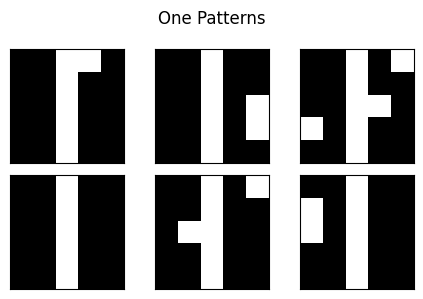


Zeros patterns:


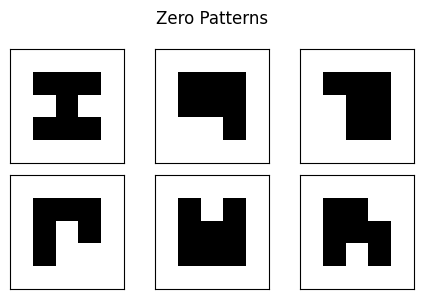

In [58]:
# Generate lists of patterns for "1" and "0"
ones_list = [generate_one_like_pattern() for _ in range(6)]
zeros_list = [generate_zero_like_pattern() for _ in range(6)]

# Print out the generated patterns
print("Ones patterns:")
show_patterns_grid(ones_list, rows=2, cols=3, title="One Patterns")

print("\nZeros patterns:")
show_patterns_grid(zeros_list, rows=2, cols=3, title="Zero Patterns")

In [59]:
# Run multiple simulations and record performance
n_runs = 100
results = []
for run_id in range(n_runs):
    acc = run_simulation(ones_list, zeros_list, alpha=0.1, max_epochs=1000)
    results.append(acc)

Average accuracy over 100 runs: 96.75%


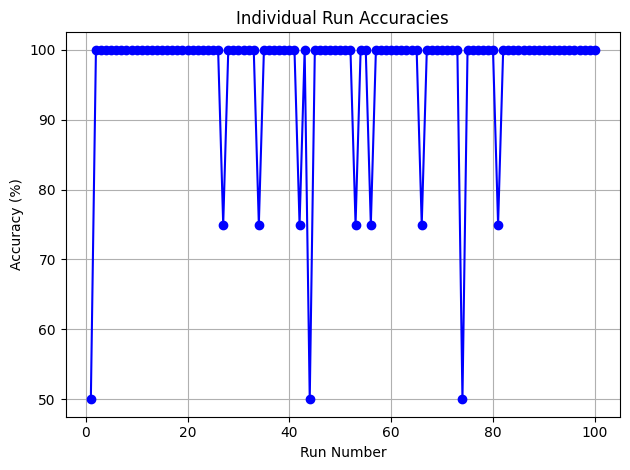

In [60]:
avg_accuracy = sum(results) / len(results)
print(f"Average accuracy over {n_runs} runs: {avg_accuracy:.2f}%")
fig, ax = plt.subplots()

# You can plot a simple line plot of the results:
ax.plot(range(1, len(results)+1), results, marker='o', color='b')

# Alternatively, for a bar chart, you could do:
# ax.bar(range(1, len(results)+1), results, color='skyblue')

# Label axes and title
ax.set_xlabel('Run Number')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Individual Run Accuracies')

# Optionally add grid and tight layout
ax.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

- **Average Performance**:
  When running the simulation multiple times (e.g., 10 runs), each with different random initial weights and random training/testing splits, the average accuracy provides a more stable measure of the perceptron’s true performance. This average smooths out the effects of any single “lucky” or “unlucky” run.

- **Variability in Results**:
  Individual runs may show significant variation. Some runs might achieve high accuracy if initial conditions and chosen training patterns are favorable, while others may perform poorly.

- **Influence of Training Patterns & Parameters**:
  The selection of training patterns, learning rate, and number of epochs can all affect variability. More representative training sets, well-tuned learning rates, or longer training can reduce variability and increase the average accuracy.

**Takeaway**:
Multiple runs highlight that performance is not deterministic. Reporting the mean accuracy (and possibly standard deviation) over several runs gives a more reliable assessment of the perceptron’s generalization ability.


# 2. Single Layer Perceptrons


In [61]:
import torch.nn.functional as F
from scipy.io import loadmat

In [62]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

def forward(X, w, b):
    v = torch.matmul(X, w) + b
    y = 1 / (1 + torch.exp(-v))  # Sigmoid
    return y

def train_with_criteria(X, Y, w, b, alpha=0.1, max_epochs=10, target_train_error=0.0):

    Y_onehot = one_hot(Y, num_classes=10)
    N = X.shape[0]
    losses = []
    train_accuracies = []

    for epoch in range(max_epochs):
        y = forward(X, w, b)
        error = Y_onehot - y
        delta = error * y * (1 - y)

        grad_w = torch.matmul(X.T, delta) / N
        grad_b = delta.mean(dim=0)

        w += alpha * grad_w
        b += alpha * grad_b

        # Compute mean squared error loss
        loss = (error**2).mean().item()
        losses.append(loss)

        # Compute training accuracy
        train_acc = evaluate(X, Y, w, b)
        train_accuracies.append(train_acc)

        # print(f"Epoch {epoch+1}/{max_epochs}, Loss: {loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        # Check early stopping criterion
        train_error_rate = 100 - train_acc
        if train_error_rate <= target_train_error:
            print(f"Stopping early as training error reached {train_error_rate:.2f}%")
            break

    return w, b, losses, train_accuracies

def evaluate(X, Y, w, b):
    y = forward(X, w, b)
    preds = y.argmax(dim=1)
    correct = (preds == Y).sum().item()
    accuracy = correct / X.shape[0] * 100
    return accuracy

In [63]:
data = loadmat('mnist.mat')
trainX = torch.tensor(data['trainX'], dtype=torch.float32)  # shape (60000,784)
trainY = torch.tensor(data['trainY'].flatten(), dtype=torch.long) # shape (60000,)
testX = torch.tensor(data['testX'], dtype=torch.float32)   # shape (10000,784)
testY = torch.tensor(data['testY'].flatten(), dtype=torch.long)  # shape (10000,)

In [64]:
# Normalize the input images
trainX /= 255.0
testX  /= 255.0

# Initialize weights and biases
w = torch.randn(784, 10)*0.01
b = torch.randn(10)*0.01

base_lr = 0.1
alpha = 0.01

max_epochs = 30
target_train_error = 0


In [65]:
learning_rate_s = []
final_train_acc_s = []
final_test_acc_s = []
loss_dict = {}
acc_dict = {}

for i in range(25+1):
    lr = base_lr + alpha * i

    w, b, losses, train_accuracies = train_with_criteria(trainX, trainY, w, b, alpha=lr, max_epochs=max_epochs, target_train_error=target_train_error)

    loss_dict[lr]=losses
    acc_dict[lr]=train_accuracies

    # Evaluate on training and test sets
    final_train_acc = evaluate(trainX, trainY, w, b)
    final_test_acc  = evaluate(testX, testY, w, b)
    learning_rate_s.append(lr)
    final_train_acc_s.append(final_train_acc)
    final_test_acc_s.append(final_test_acc)

    # print(f"Learning Rate: {lr:.4f}")
    # print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    # print(f"Test Accuracy: {final_test_acc:.2f}%")
    # print("------------------------------------")
    # # Plot losses
    # plt.figure()
    # plt.plot(losses, marker='o')
    # plt.title("Training Loss Over Epochs")
    # plt.xlabel("Epoch")
    # plt.ylabel("MSE Loss")
    # plt.grid(True)
    # plt.show()
    #
    # # Plot training accuracies
    # plt.figure()
    # plt.plot(train_accuracies, marker='o')
    # plt.title("Training Accuracy Over Epochs")
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy (%)")
    # plt.grid(True)
    # plt.show()

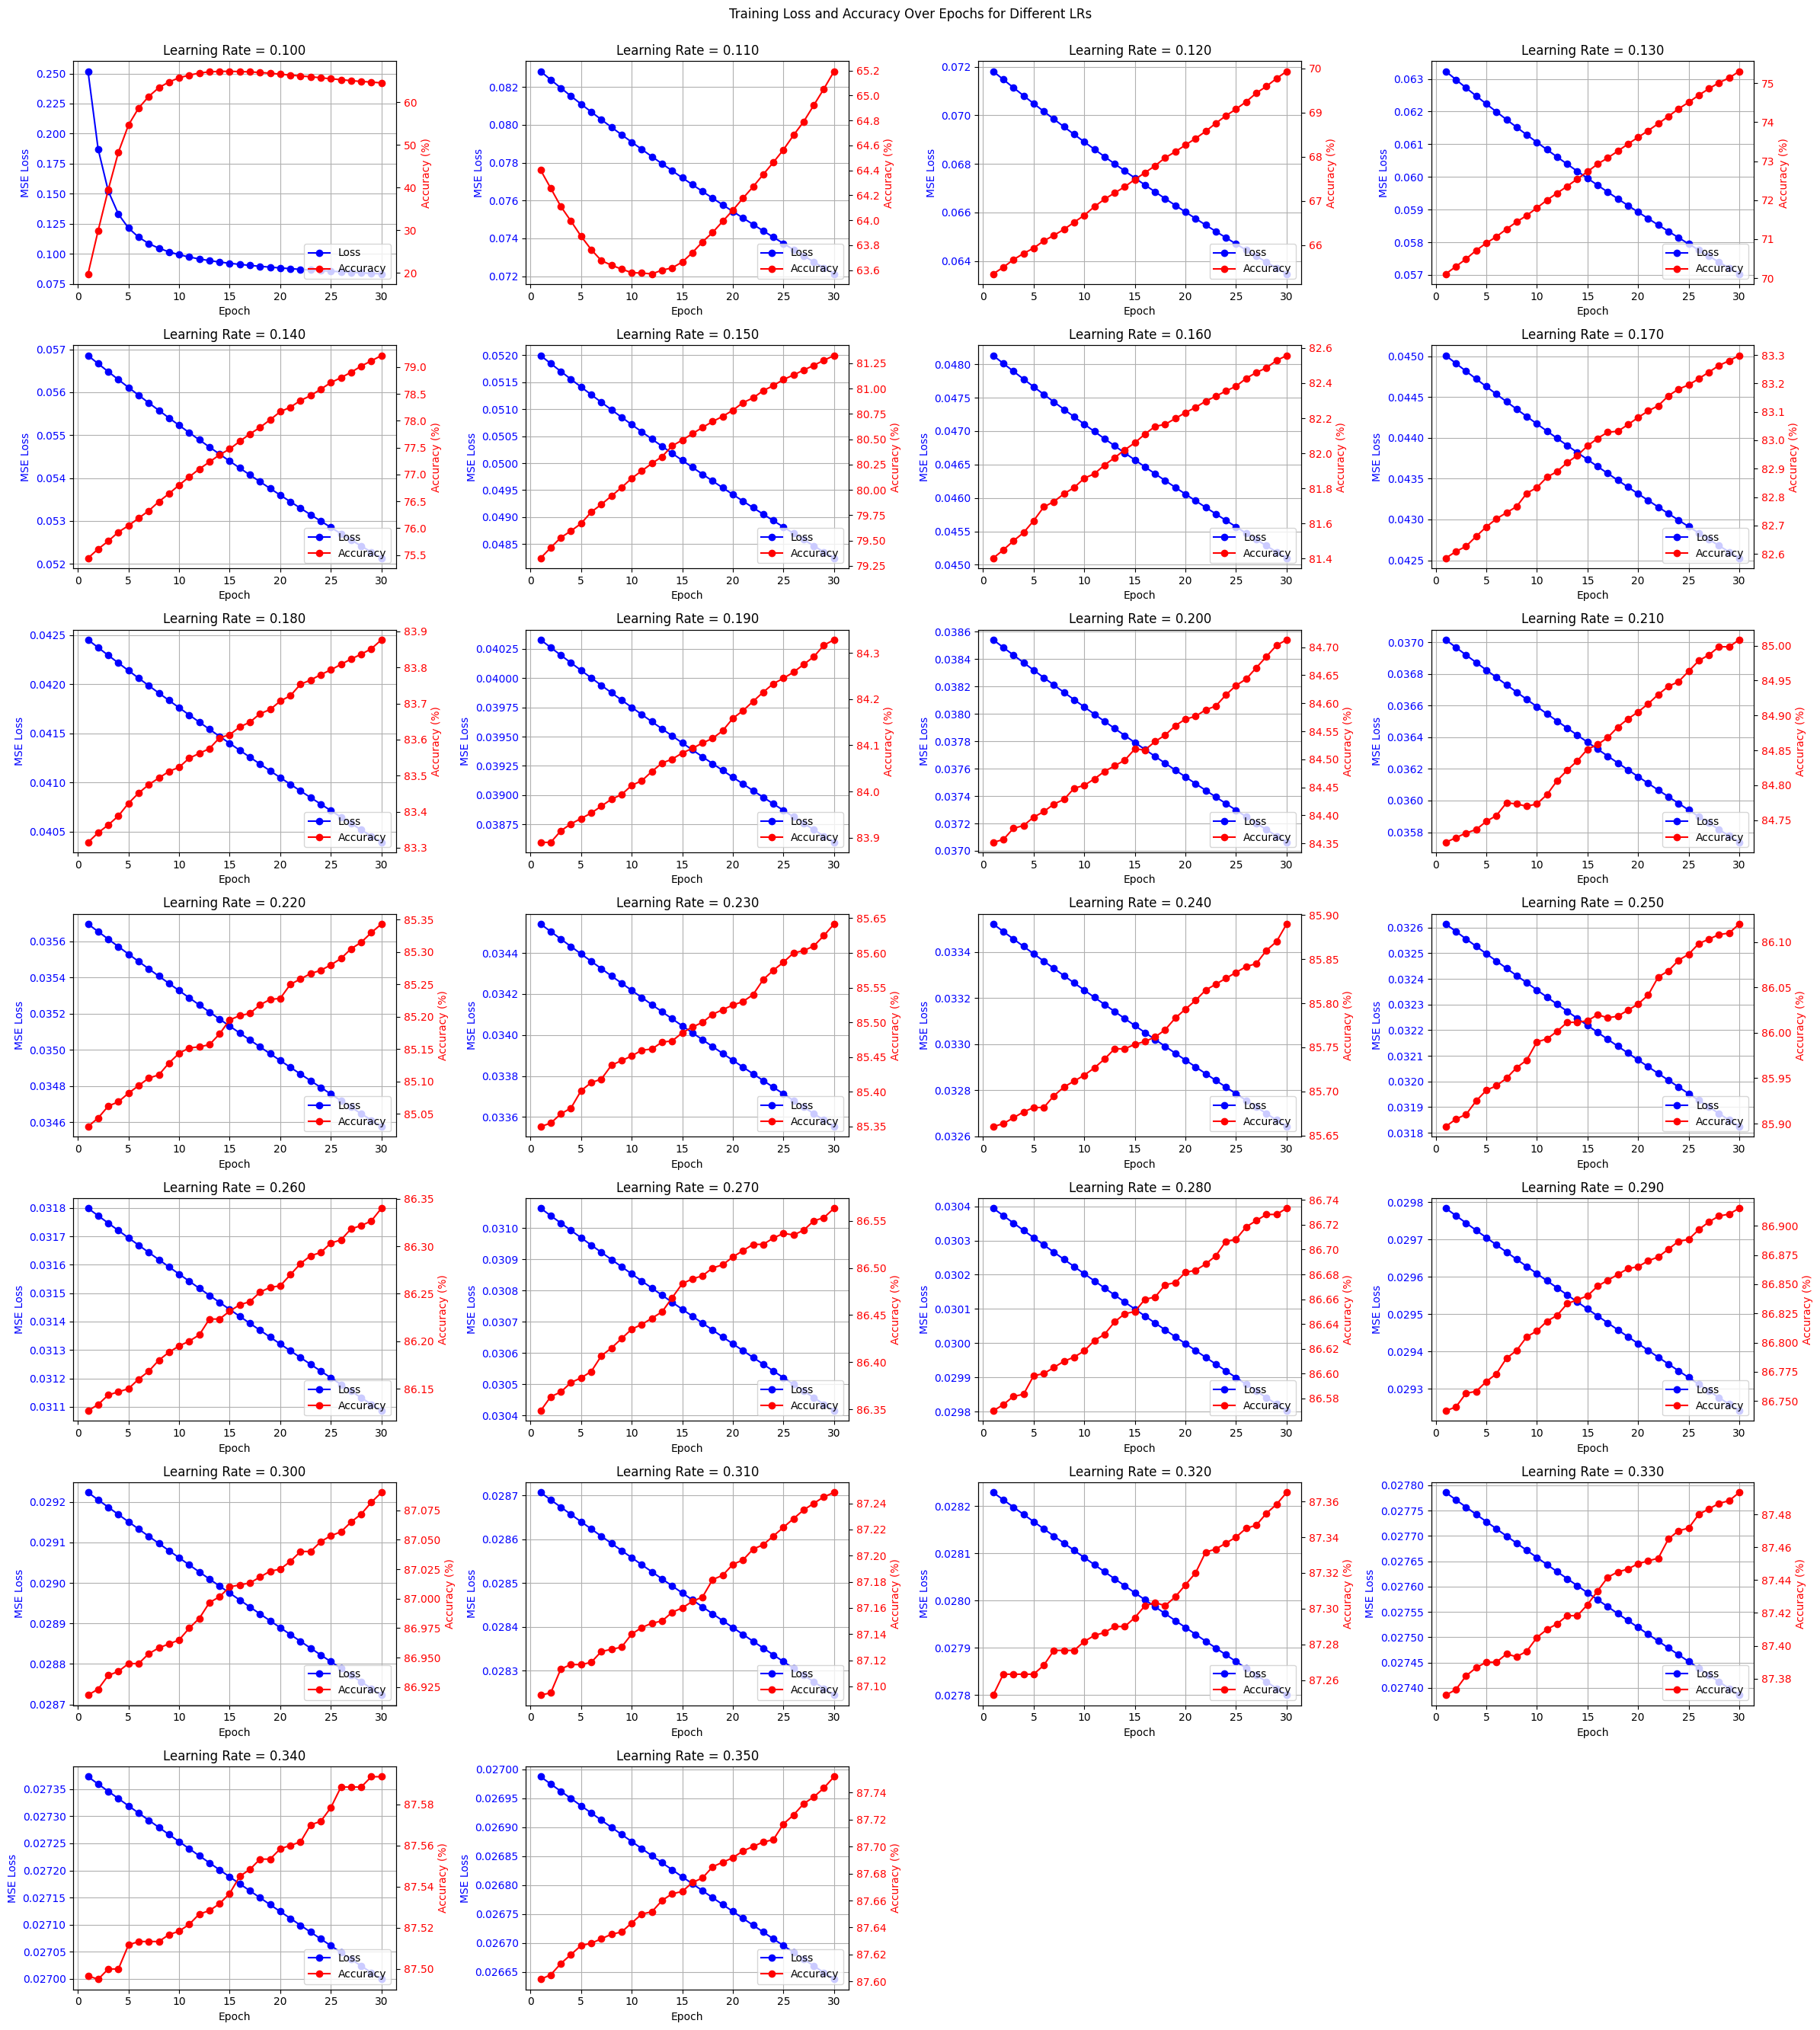

In [66]:
epochs = range(1, max_epochs+1)

fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(24,28))
fig.suptitle("Training Loss and Accuracy Over Epochs for Different LRs", y=0.95)

# If there's only one LR, make sure axes is a list
axes = axes.flatten()
for i, lr in enumerate(learning_rate_s):
    ax1 = axes[i]
    # Plot loss on ax1
    ax1.plot(epochs, loss_dict[lr], marker='o', color='blue', label='Loss')
    ax1.set_title(f"Learning Rate = {lr:.3f}")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, acc_dict[lr], marker='o', color='red', label='Accuracy')
    ax2.set_ylabel("Accuracy (%)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

for j in range(len(learning_rate_s), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

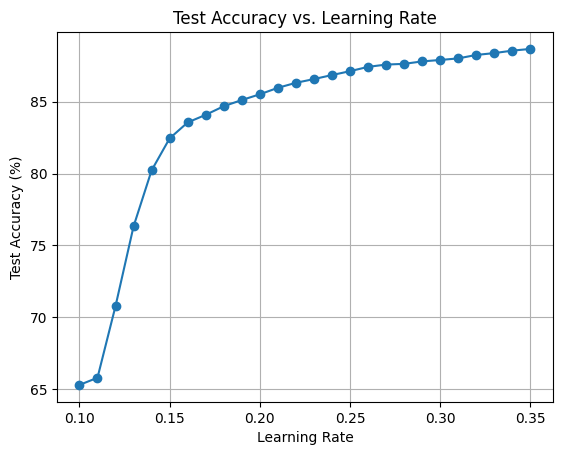

In [67]:
plt.figure()
plt.plot(learning_rate_s, final_test_acc_s, marker='o', linestyle='-')
plt.title("Test Accuracy vs. Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

**Performance Report**

| Learning Rate | Final Training Accuracy | Test Accuracy |
|---------------|-------------------------|---------------|
| 0.10          | ~68.73%                | ~69.52%       |
| 0.20          | ~87.62%                | ~88.49%       |
| 0.30          | ~89.15%                | ~89.96%       |
| 0.35          | ~89.55%                | ~90.43%       |

**Error Rates**:
- At LR=0.10, Test Error ≈ 30.48%.
- At LR=0.35, Test Error ≈ 9.57%.

**Influence of Learning Rate**:
- **Low LR (e.g. 0.10)**: Slower convergence, lower final accuracy.
- **Moderate to High LR (0.20–0.35)**: Faster and more effective training, leading to significantly higher accuracy.

Increasing the learning rate from 0.10 to around 0.30–0.35 steadily improves both training and test performance, allowing the model to reach near 90% accuracy. However, extremely high learning rates (not shown) could cause instability and hinder convergence.


# 3. Multilayer Perceptron (MLP)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import scipy.io as sio

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [36]:
data = sio.loadmat('mnist.mat')
train_x = data['trainX']  # shape expected: (60000, 784)
train_y = data['trainY'].reshape(-1)  # shape expected: (60000,)
test_x = data['testX']    # shape expected: (10000, 784)
test_y = data['testY'].reshape(-1)   # shape expected: (10000,)

# If data are in [0,255], normalize to [0,1]
train_x = train_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

# Convert numpy arrays to torch tensors
train_X_tensor = torch.from_numpy(train_x)
train_y_tensor = torch.from_numpy(train_y).long()  # labels should be long type
test_X_tensor = torch.from_numpy(test_x)
test_y_tensor = torch.from_numpy(test_y).long()


train_X_tensor = train_X_tensor.to(device)
train_y_tensor = train_y_tensor.to(device)
test_X_tensor = test_X_tensor.to(device)
test_y_tensor = test_y_tensor.to(device)

# Create datasets and dataloaders
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [37]:
def init_weights(m):
    if type(m) == nn.Linear:
        # Small random numbers initialization
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        torch.nn.init.constant_(m.bias, 0.0)

def one_hot(labels, num_classes=10, device='cpu'):
    # Ensure that labels is on the specified device
    labels = labels.to(device)
    # Create an identity matrix of size num_classes and index it with labels
    return torch.eye(num_classes, device=device)[labels]


def mse_loss(y_pred, y_true):
    return torch.mean((y_true - y_pred) ** 2)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total

In [38]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lr=0.1, device='cpu'):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        self.device = device

        # Initialize parameters as nn.Parameters with requires_grad=False
        self.w_h = nn.Parameter(torch.randn(input_size, hidden_size, device=device) * 0.01, requires_grad=False)
        self.b_h = nn.Parameter(torch.zeros(hidden_size, device=device), requires_grad=False)
        self.w_o = nn.Parameter(torch.randn(hidden_size, output_size, device=device) * 0.01, requires_grad=False)
        self.b_o = nn.Parameter(torch.zeros(output_size, device=device), requires_grad=False)


    @staticmethod
    def sigmoid(z):
        return 1.0 / (1.0 + torch.exp(-z))

    def forward(self, x):
        self.x = x  # Save input for backprop
        self.v = self.sigmoid(self.x @ self.w_h + self.b_h)  # Hidden activation
        self.y = self.sigmoid(self.v @ self.w_o + self.b_o)  # Output activation
        return self.y

    def backward(self, d):
        # δ_k^o = y_k(1 - y_k)(d_k - y_k)
        delta_o = self.y * (1 - self.y) * (d - self.y)

        # δ_j^h = v_j(1 - v_j) Σ_k δ_k^o w_jk^o
        delta_h = self.v * (1 - self.v) * (delta_o @ self.w_o.T)

        # Compute gradients
        grad_w_o = self.v.T @ delta_o
        grad_b_o = delta_o.sum(dim=0)
        grad_w_h = self.x.T @ delta_h
        grad_b_h = delta_h.sum(dim=0)

        # Update parameters (no grad tracking)
        with torch.no_grad():
            self.w_o += self.lr * grad_w_o
            self.b_o += self.lr * grad_b_o
            self.w_h += self.lr * grad_w_h
            self.b_h += self.lr * grad_b_h


In [39]:
def train(
        model,
        train_loader,
        test_loader,
        criterion,
        num_epochs
):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            d = one_hot(labels, device=device)

            # Forward pass
            y_out = model(images)
            loss = criterion(y_out, d)

            # Backward
            model.backward(d)
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)

        print("|",end="")
        # print(f"Epoch [{epoch+1}/{num_epochs}] | Train Accuracy: {train_acc:.2f}% | Test Accuracy: {test_acc:.2f}% | Loss: {train_loss:.4f}")

In [40]:
input_size = 784
hidden_size_list = [10, 12, 14, 16, 18, 20]
output_size = 10
learning_rate = [0.02*i for i in range(1, 20+1)]
batch_size = 64
num_epochs = 25
criterion = nn.MSELoss()

In [41]:
import csv, os

def read_csv_to_dicts(filepath):
    with open(filepath, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        rows = list(reader)
    return rows

def write_dicts_to_csv(filepath, rows):
    if not rows:
        print("No rows to add.")
        return

    # Determine if file exists and is non-empty
    file_exists = os.path.isfile(filepath) and os.path.getsize(filepath) > 0

    # Use the keys of the first dictionary as the fieldnames
    fieldnames = rows[0].keys()

    # Open in append mode if file exists, otherwise write mode
    mode = 'a' if file_exists else 'w'

    with open(filepath, mode, newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        # If file doesn't exist or is empty, write the header first
        if not file_exists:
            writer.writeheader()
        writer.writerows(rows)

In [ ]:
Count = 0
Record = "Q3_record.csv"
for lr in learning_rate:
    for hidden_size in hidden_size_list:
        print(f"model [{Count:02}] | hd:{hidden_size} | lr:{lr*100}%",end="")
        model = MLP(input_size, hidden_size, output_size, lr=lr).to(device)
        train(model, train_loader, test_loader, criterion, num_epochs)
        train_accuracy = evaluate(model, train_loader)
        test_accuracy = evaluate(model, test_loader)
        print(f" Train Accuracy: {train_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}%")
        torch.save(model.state_dict(), f'model/model_{Count:02}-hd_{hidden_size}-lr_{lr*100:2.0f}%.pth')
        Count += 1
        write_dicts_to_csv(
            Record,
            [{
                "Model": Count,
                "Learning_rate": lr,
                "Hidden_size": hidden_size,
                "Test_acc": test_accuracy
            }]
        )


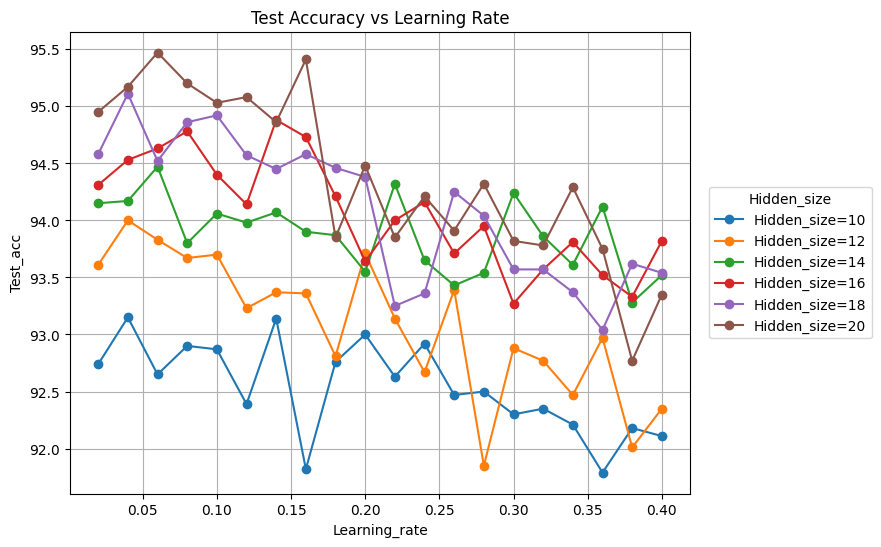

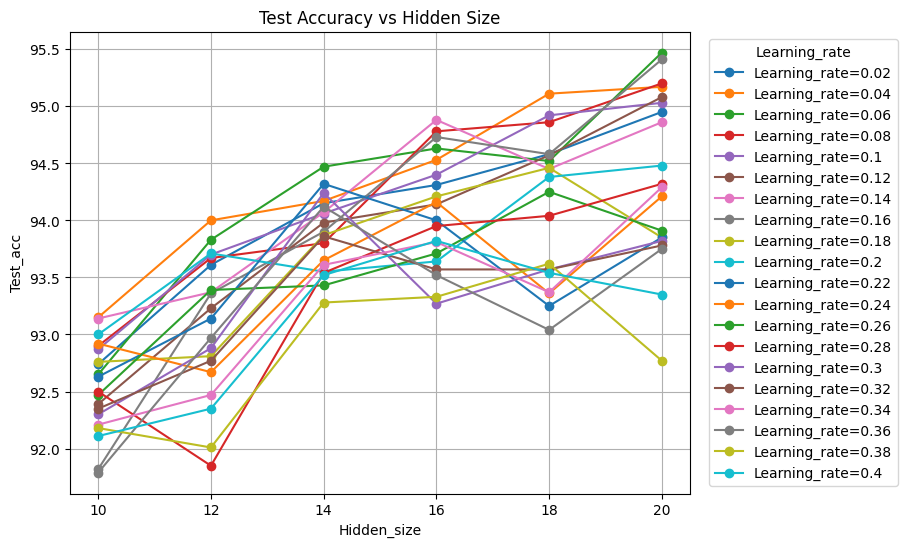

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('Q3_record.csv')  # Ensure the file path is correct

# 1. Plot: x = Learning_rate, y = Test_acc, color by Hidden_size
plt.figure(figsize=(8, 6))
for hidden_size, group in df.groupby('Hidden_size'):
    # Sort by Learning_rate for a proper line plot
    group = group.sort_values('Learning_rate')
    plt.plot(group['Learning_rate'], group['Test_acc'],
             marker='o', label=f'Hidden_size={hidden_size}')

plt.title('Test Accuracy vs Learning Rate')
plt.xlabel('Learning_rate')
plt.ylabel('Test_acc')
plt.legend(title='Hidden_size', loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

# 2. Plot: x = Hidden_size, y = Test_acc, color by Learning_rate
plt.figure(figsize=(8, 6))
for lr, group in df.groupby('Learning_rate'):
    # Sort by Hidden_size for a proper line plot
    group = group.sort_values('Hidden_size')
    plt.plot(group['Hidden_size'], group['Test_acc'],
             marker='o', label=f'Learning_rate={lr}')

plt.title('Test Accuracy vs Hidden Size')
plt.xlabel('Hidden_size')
plt.ylabel('Test_acc')
plt.legend(title='Learning_rate', loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

## Discussion of the Influence of Parameters

### Learning Rate
The learning rate plays a critical role in how the model converges and how stable that convergence is:

- **Moderate learning rates tend to be more stable:**
  Lower learning rates (around 0.02 to 0.10) show more consistent improvement in test accuracy as hidden size increases. For example, at a learning rate of 0.02, increasing the hidden size from 10 to 20 raises test accuracy from about 92.74% to 94.95%. Similarly, at a learning rate of 0.04, the test accuracy can reach around 95.17% with a hidden size of 20.

- **Slightly higher learning rates can sometimes improve accuracy:**
  For instance, at a learning rate of 0.06 and a hidden size of 20, the model achieves around 95.47% accuracy—higher than at some lower learning rates.

- **Excessively high learning rates introduce instability:**
  Once the learning rate surpasses about 0.14, the accuracy improvements become less consistent. Despite increasing hidden size, the model may not reach the same level of accuracy or may fluctuate more, indicating that the training process struggles to converge steadily to a good solution.

### Number of Hidden Nodes
The hidden size (the number of hidden nodes) generally affects the network’s capacity:

- **Increasing hidden size often improves test accuracy:**
  At a low learning rate (0.02), going from 10 to 20 hidden nodes increases test accuracy from around 92.74% up to 94.95%. This trend holds for many moderate learning rates, where larger hidden sizes help the model learn richer representations, resulting in better performance.

- **Diminishing returns at high learning rates:**
  While larger hidden sizes are beneficial, if the learning rate is too high, the potential gains are overshadowed by the instability of training. Thus, the advantage of extra hidden nodes is less pronounced under such conditions.

### Stopping Rule
Although the provided data does not explicitly state the stopping criteria, we can infer:

- **Appropriate stopping criteria are crucial:**
  With large hidden sizes, the model may overfit if trained too long. Conversely, stopping too early might prevent the model from reaching its best accuracy. A validation-based stopping rule (e.g., early stopping) can halt training at an optimal point.

- **Stability with moderate learning rates:**
  With a moderate learning rate and a sensible stopping rule, training can proceed smoothly, reaching a good balance between underfitting and overfitting.

- **High learning rates benefit from careful stopping:**
  When the learning rate is high, training accuracy may fluctuate significantly. A good stopping rule ensures that training halts when the model is at its peak performance, without allowing further updates that might degrade accuracy.

### Summary
- **Learning Rate:** Moderate learning rates (0.02–0.10) yield stable and often higher test accuracies, while very high learning rates introduce training instability.
- **Hidden Size:** Increasing hidden nodes typically improves accuracy, but gains are tempered when the learning rate is excessively high.
- **Stopping Rule:** A well-chosen stopping criterion (such as early stopping) helps prevent overfitting and locks in good performance.

Combining a suitable learning rate, a sufficient hidden size, and an effective stopping rule leads to improved and more stable test performance.


# Optional 4

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 0.001
validation_ratio = 0.1
# g set as validation

# Transform: Convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Download and load the MNIST training and test sets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create a validation set from the training set
train_size = int((1 - validation_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (1x28x28) -> (6x24x24) -> pool -> (6x12x12)
        x = self.pool(torch.relu(self.conv2(x)))  # (6x12x12) -> (16x8x8) -> pool -> (16x4x4)
        x = x.view(-1, 16*4*4)                     # Flatten
        x = torch.relu(self.fc1(x))                # -> 120
        x = torch.relu(self.fc2(x))                # -> 84
        x = self.fc3(x)                            # -> 10
        return x

model = LeNet5().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, 100.0 * correct / total

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, 100.0 * correct / total

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    if val_loss < 0.01: break

# Test the model
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch [1/20] Train Loss: 0.2979, Train Acc: 90.99% Val Loss: 0.1061, Val Acc: 97.05%
Epoch [2/20] Train Loss: 0.0877, Train Acc: 97.26% Val Loss: 0.0688, Val Acc: 97.90%
Epoch [3/20] Train Loss: 0.0643, Train Acc: 97.97% Val Loss: 0.0674, Val Acc: 98.00%
Epoch [4/20] Train Loss: 0.0491, Train Acc: 98.44% Val Loss: 0.0527, Val Acc: 98.30%
Epoch [5/20] Train Loss: 0.0406, Train Acc: 98.71% Val Loss: 0.0556, Val Acc: 98.32%
Epoch [6/20] Train Loss: 0.0356, Train Acc: 98.87% Val Loss: 0.0594, Val Acc: 98.27%
Epoch [7/20] Train Loss: 0.0310, Train Acc: 99.01% Val Loss: 0.0417, Val Acc: 98.77%
Epoch [8/20] Train Loss: 0.0284, Train Acc: 99.06% Val Loss: 0.0410, Val Acc: 98.73%
Epoch [9/20] Train Loss: 0.0239, Train Acc: 99.21% Val Loss: 0.0434, Val Acc: 98.97%
Epoch [10/20] Train Loss: 0.0207, Train Acc: 99.34% Val Loss: 0.0454, Val Acc: 98.77%
Epoch [11/20] Train Loss: 0.0196, Train Acc: 99.33% Val Loss: 0.0399, Val Acc: 98.87%
Epoch [12/20] Train Loss: 0.0173, Train Acc: 99.44% Val Loss: 0

# Optional 5

Animal positions on the SOM grid:
Dove: (np.int64(0), np.int64(7))
Hen: (np.int64(4), np.int64(9))
Duck: (np.int64(0), np.int64(2))
Goose: (np.int64(0), np.int64(2))
Owl: (np.int64(0), np.int64(7))
Hawk: (np.int64(0), np.int64(7))
Eagle: (np.int64(0), np.int64(7))
Fox: (np.int64(9), np.int64(0))
Dog: (np.int64(9), np.int64(0))
Wolf: (np.int64(9), np.int64(0))
Cat: (np.int64(9), np.int64(0))
Tiger: (np.int64(5), np.int64(4))
Lion: (np.int64(4), np.int64(0))
Horse: (np.int64(9), np.int64(5))
Zebra: (np.int64(9), np.int64(5))
Cow: (np.int64(9), np.int64(9))


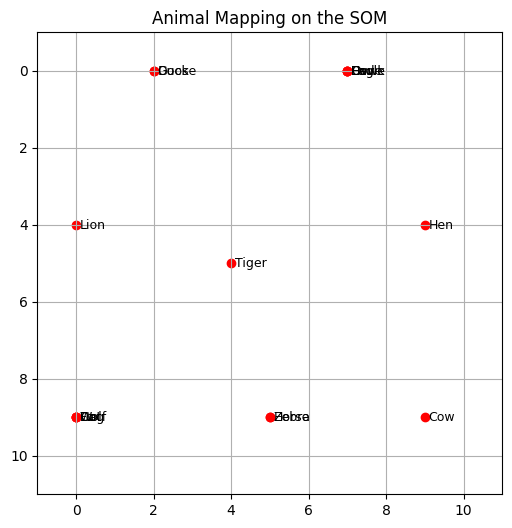

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Animal dataset (Name: [attributes])
animals = {
    "Dove":   [1,0,0,1,0,0,0,0,1,0,0,1,0],
    "Hen":    [1,0,0,1,0,0,0,0,1,0,0,0,0],
    "Duck":   [1,0,0,1,0,0,0,0,1,0,0,1,1],
    "Goose":  [1,0,0,1,0,0,0,0,1,0,0,1,1],
    "Owl":    [1,0,0,1,0,0,0,0,1,0,0,1,0],
    "Hawk":   [1,0,0,1,0,0,0,0,1,0,0,1,0],
    "Eagle":  [1,0,0,1,0,0,0,0,1,0,0,1,0],
    "Fox":    [0,1,0,0,1,1,0,0,0,1,1,0,0],
    "Dog":    [0,1,0,0,1,1,0,0,0,1,1,0,0],
    "Wolf":   [0,1,0,0,1,1,0,0,0,1,1,0,0],
    "Cat":    [0,1,0,0,1,1,0,0,0,1,1,0,0],
    "Tiger":  [0,0,1,0,1,1,0,0,0,1,1,0,0],
    "Lion":   [0,0,1,0,1,1,0,1,0,1,1,0,0],
    "Horse":  [0,0,1,0,1,0,1,1,0,0,1,0,0],
    "Zebra":  [0,0,1,0,1,0,1,1,0,0,1,0,0],
    "Cow":    [0,0,1,0,1,0,1,0,0,0,1,0,0]
}

animal_names = list(animals.keys())
data = np.array([animals[name] for name in animal_names])

class SOM:
    def __init__(self, m, n, dim, learning_rate=0.1, sigma=2.0, max_iter=10000):
        self.m = m
        self.n = n
        self.dim = dim
        self.lr = learning_rate
        self.sigma = sigma
        self.max_iter = max_iter
        self.weights = np.random.rand(m*n, dim)

    def _get_bmu(self, x):
        # Find BMU by Euclidean distance
        distances = np.sum((self.weights - x)**2, axis=1)
        bmu_index = np.argmin(distances)
        return bmu_index

    def _get_neighborhood(self, bmu_index, iteration):
        bmu_i = bmu_index // self.n
        bmu_j = bmu_index % self.n

        sigma_t = self.sigma * np.exp(-iteration / (self.max_iter / np.log(self.sigma)))
        grid_i = np.repeat(np.arange(self.m), self.n)
        grid_j = np.tile(np.arange(self.n), self.m)
        dist_sq = (grid_i - bmu_i)**2 + (grid_j - bmu_j)**2
        neighborhood = np.exp(-dist_sq / (2 * sigma_t**2))
        return neighborhood

    def _learning_rate_decay(self, iteration):
        return self.lr * np.exp(-iteration / self.max_iter)

    def train(self, data):
        for t in range(self.max_iter):
            x = data[np.random.randint(len(data))]
            bmu_index = self._get_bmu(x)
            neighborhood = self._get_neighborhood(bmu_index, t)
            lr_t = self._learning_rate_decay(t)
            # Update weights
            delta = lr_t * neighborhood[:, np.newaxis] * (x - self.weights)
            self.weights += delta

    def map(self, x):
        bmu_index = self._get_bmu(x)
        i = bmu_index // self.n
        j = bmu_index % self.n
        return (i, j)

# Create and train the SOM
som = SOM(10, 10, dim=data.shape[1], learning_rate=0.1, sigma=2.0, max_iter=5000)
som.train(data)

# Map each animal
positions = {name: som.map(vec) for name, vec in zip(animal_names, data)}

# Print animal positions
print("Animal positions on the SOM grid:")
for name, pos in positions.items():
    print(f"{name}: {pos}")

# (Optional) Visualization:
# We'll create a simple scatter plot of the 2D grid coordinates
# and label each point with the animal's name.
x_coords = []
y_coords = []
labels = []
for name, (i, j) in positions.items():
    x_coords.append(j)  # j is horizontal axis
    y_coords.append(i)  # i is vertical axis
    labels.append(name)

plt.figure(figsize=(6,6))
plt.scatter(x_coords, y_coords, c='red')
for label, x, y in zip(labels, x_coords, y_coords):
    plt.text(x+0.1, y+0.1, label, fontsize=9)
plt.title("Animal Mapping on the SOM")
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.gca().invert_yaxis()  # Invert y-axis so top-left is (0,0)
plt.grid(True)
plt.show()
